# Multiscale and Wideband Imaging Demo

This simulation and imaging demo is meant to convey the following

 - How to simulate interferometery data with interesting sky structures that include multi-scale and spectral features.
 - Run Cube, MFS, and MT-MFS imaging to showcase the effects of multi-frequency observations.
 - Compare MS-Clean with ASP-Clean for Cubes
 - (Later) Compare MS-MT-MFS-Clean with ASP-MT-Clean for Wideband imaging. 
 
***

In [1]:
%run -i Sim_Multiscale_Wideband_Script.py
%run -i Display_Experiments_Script.py
#%matplotlib widget
#%matplotlib inline

## Make an empty Measurement Set

In [2]:
makeMSFrame(msn='sim_data', tel='VLA')

Making an MS named : sim_data_VLA.ms


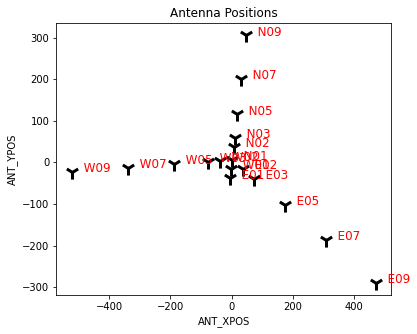

In [3]:
XPlot(vis='sim_data_VLA.ms', ptype='plotants')#,forceconvert=True)

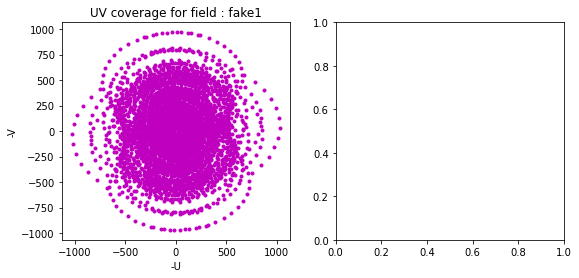

In [4]:
XPlot(vis='sim_data_VLA.ms', ptype='uvcov')

In [5]:
listobs_jupyter(vis='sim_data_VLA.ms')

           MeasurementSet Name:  /export/home/riya/rurvashi/Work/SimScripts/Sim_Notebooks/sim_data_VLA.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: VLA(18 antennas)
Data records: 2754       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2020/21:18:42.8   to   04-Oct-2020/07:18:42.8 (UTC)

Fields: 1
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake1               19:59:28.500000 +40.40.00.00000 J2000   0           2754
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      LBand      5   TOPO    1000.000    200000.000   1000000.0   1400.0000   RR  LL
Antennas: 18 'name'='station' 
   ID=   0-5: 'W01'='P', 'W02'='P', 'W03'='P', 'W05'='P', 'W07'='P', 'W09'='P', 
   ID=  6-11: 'E01'='P', 'E02'='P', 'E03'='P', 'E05'='P', 'E07'='P', 'E09'='P', 
   ID= 12

## Make a True Sky Model 

There are three options in this script
- 'basic' : Two point sources with alpha=0.0 and -0.5, and one round Gaussian with sigma of 7.0arcmin and alpha=-1.0
- 'simple' : Two overlapping Gaussians with positive and negative spectral index, creating spectral curvature in the middle requring a higher order spectral fit in that region. Plus, two control point sources
- 'jet' : A jet+lobe structure with multiscale structure in the lobe and a narrow line of emission in the jet. The edges of the narrow line is a use case where mtmfs sometimes has a hard time getting the spectral index right.

True spectral index values may be derived either from the simulation script, or by calculating a pixel-by-pixel spectral fit to the smoothed truth image cube below. 

In [6]:
source = 'basic'
source = 'simple'
source = 'jet'

In [7]:
%run -i Sim_Multiscale_Wideband_Script.py
%run -i Display_Experiments_Script.py

## Make the component list
makeCompList(clname_true='sim_'+source+'_vla.cl',tel='VLA',stype=source)
## Make an empty CASA image
makeEmptyImage(imname_true='sim_'+source+'_vla.im',tel='VLA')
## Evaluate the component list onto the CASA image
evalCompList(clname='sim_'+source+'_vla.cl', imname='sim_'+source+'_vla.im')

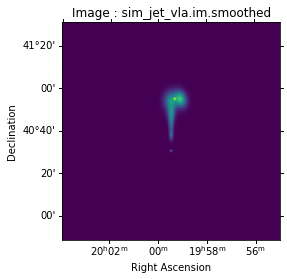

In [8]:
## Smooth to an angular resolution of 50arcsec. This is approx what mfs will give. 
smoothModel(imname='sim_'+source+'_vla.im',rbeam='60arcsec')
displayImage(imname='sim_'+source+'_vla.im.smoothed')#,scale='sqrt')

Cube shape :  [512 512   1   5]
Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...


/export/home/riya/rurvashi/Packages/local_python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Save outputs


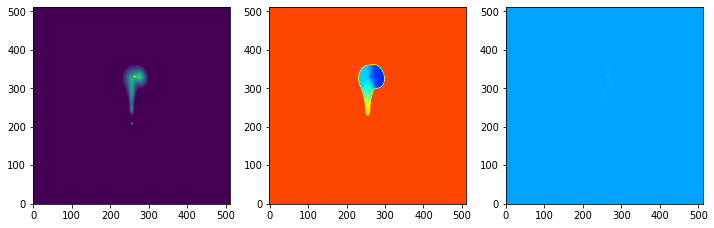

In [9]:
%run -i Sim_Multiscale_Wideband_Script.py
fit_spectrum(cubename='sim_'+source+'_vla.im.smoothed',
             intensity='sim_'+source+'_int.im',
             alpha='sim_'+source+'_alpha.im',
             beta='sim_'+source+'_beta.im',
             pixt=0.15)

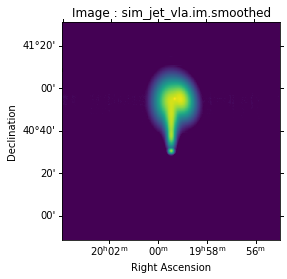

In [10]:
### Display with a different colormap stretch to see the fainter emission
displayImage(imname='sim_'+source+'_vla.im.smoothed',scale='sqrt')

## Simulate visibilities from the sky model

Simulate visibilities for the true sky model, using the standard gridder (no primary beams)

In [11]:
%run -i Sim_Multiscale_Wideband_Script.py
%run -i Display_Experiments_Script.py


In [12]:
predictImager(msname='sim_data_VLA.ms',
              imname_true='sim_'+source+'_vla.im', 
              tel='VLA',
              gridder='standard')
copyModelToData(msname='sim_data_VLA.ms')

['fake1']


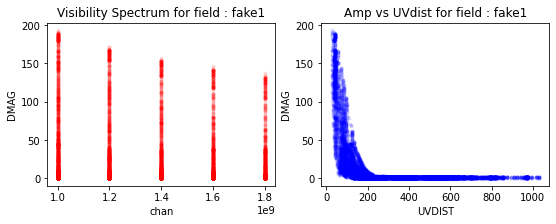

In [13]:
XPlot(vis='sim_data_VLA.ms', ptype='amp-freq-uvdist')#,forceconvert=True)

In [14]:
### Add noise.... later
#addNoiseSim(msname='sim_data_VLA.ms')

## Run Imaging Tests

### Hogbom Cube

In [15]:
os.system('rm -rf try_cube_hogbom.*')
tclean(vis='sim_data_VLA.ms',imagename='try_cube_hogbom',imsize=512,cell='12.0arcsec',
       specmode='cube',interpolation='nearest',nchan=5,start='1.0GHz',width='0.2GHz',
       pblimit=-1e-05,deconvolver='hogbom',niter=5000)

{}

Residual RMS : 0.0678622


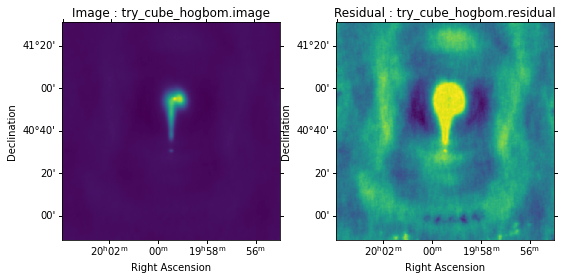

In [16]:
display_image(imprefix='try_cube_hogbom')

Cube shape :  [512 512   1   5]
Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...
Save outputs


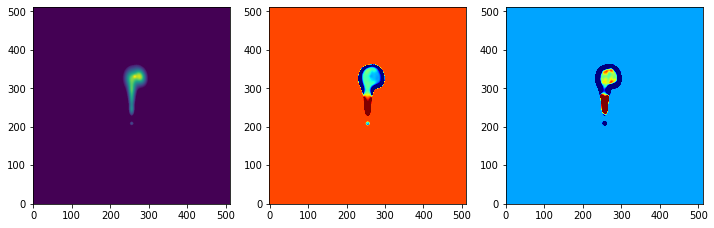

In [17]:
smoothModel(imname='try_cube_hogbom.image',rbeam='94.0arcsec')
fit_spectrum(cubename='try_cube_hogbom.image.smoothed',
             intensity='try_cube_hogbom.intensity',
             alpha='try_cube_hogbom.alpha',
             beta='try_cube_hogbom.beta',
             pixt=0.5)

### Multiscale Cube

In [18]:
os.system('rm -rf try_cube_multiscale.*')
tclean(vis='sim_data_VLA.ms',imagename='try_cube_multiscale',imsize=512,cell='12.0arcsec',
       specmode='cube',interpolation='nearest',nchan=5,start='1.0GHz',width='0.2GHz',
       pblimit=-1e-05,deconvolver='multiscale',niter=5000,scales=[0,3,10])

{}

Residual RMS : 0.3964169


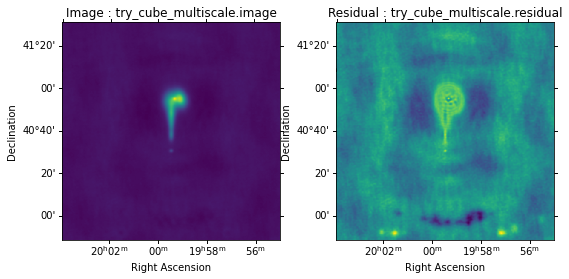

In [19]:
display_image(imprefix='try_cube_multiscale')

In [20]:
smoothModel(imname='try_cube_multiscale.image',rbeam='94.0arcsec')
fit_spectrum(cubename='try_cube_multiscale.image.smoothed',
             intensity='try_cube_multiscale.intensity',
             alpha='try_cube_multiscale.alpha',
             beta='try_cube_multiscale.beta',
             pixt=1.5)

Cube shape :  [512 512   1   5]
Frequencies (Ghz) :  [1.  1.2 1.4 1.6 1.8]
Start fitting...


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

### MT-MFS with multiscale

Image with MTMFS and multiple scales. 

In [ ]:
os.system('rm -rf try_mtmfs.*')
tclean(vis='sim_data_VLA.ms',imagename='try_mtmfs',imsize=512,cell='12.0arcsec',
       specmode='mfs',reffreq='1.5GHz',pblimit=-1e-05,nterms=2,
       deconvolver='mtmfs',niter=5000,cycleniter=1000,threshold='0.2Jy',scales=[0,3,6,12])

In [ ]:
%run -i Display_Experiments_Script.py
display_image(imprefix='try_mtmfs',multiterm=True)